<a href="https://colab.research.google.com/github/sawandarekar/era_v3_assignment_7/blob/main/era_v3_assignment_7_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:
- Reduce parameters bellow 10k count
- Make sure, defined model get trained, also add GAP, MaxPool,
- Achive test accuracy > 99.40%
- Limit the 20 epoch

## Result:
- Parameters: 9,180
- Best Training Accuracy: 99.32%
- Best Test Accuracy: 99.42%

## Analysis:
- model trained with 9k parameters
- Added Batch Normalization, MaxPool2d and dropout = 0.1
- skip added
- Model test accuracy achieved 99.42% on 15th epoch
- Model is Good fitting from 19th epoch (training accuracy: 99.32% test accuracy: 99.35%)
- After adding image augmentations and StepLR, model is looks good on epoch 13th  (training accuracy: 99.16% test accuracy: 99.46%)

In [42]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [62]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [63]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [64]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Find mean and std values

In [67]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Model Defination

In [68]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        drop_out_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 26*26   RF=3*3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 24*24  RF=5*5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 22*22   RF=7*7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output_size = 11*11  RF=14*14

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 9*9   RF=16*16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 7*7.  RF=18*18


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 5*5.  RF=

        self.gap = nn.AvgPool2d(5)

        self.skip1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        self.skip2 = nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False)



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = self.gap(x)

        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)



## Model Parameters Deatils

In [69]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,728
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13 

## Training valiating

In [74]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'EPOCH:{epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} LR={optimizer.param_groups[0]["lr"]}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and testing model for each EPOCH

In [75]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH:0 Loss=0.050359949469566345 Batch_id=937 Accuracy=93.87 LR=0.01: 100%|██████████| 938/938 [01:05<00:00, 14.37it/s]



Test set: Average loss: 0.0531, Accuracy: 9840/10000 (98.40%)



EPOCH:1 Loss=0.14306209981441498 Batch_id=937 Accuracy=98.08 LR=0.01: 100%|██████████| 938/938 [01:07<00:00, 13.93it/s]  



Test set: Average loss: 0.0456, Accuracy: 9864/10000 (98.64%)



EPOCH:2 Loss=0.011142509058117867 Batch_id=937 Accuracy=98.32 LR=0.01: 100%|██████████| 938/938 [01:07<00:00, 14.00it/s] 



Test set: Average loss: 0.0315, Accuracy: 9900/10000 (99.00%)



EPOCH:3 Loss=0.055059969425201416 Batch_id=937 Accuracy=98.54 LR=0.01: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s] 



Test set: Average loss: 0.0324, Accuracy: 9895/10000 (98.95%)



EPOCH:4 Loss=0.09678667783737183 Batch_id=937 Accuracy=98.59 LR=0.01: 100%|██████████| 938/938 [01:08<00:00, 13.77it/s]  



Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)



EPOCH:5 Loss=0.02437777630984783 Batch_id=937 Accuracy=98.76 LR=0.01: 100%|██████████| 938/938 [01:01<00:00, 15.32it/s]  



Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)



EPOCH:6 Loss=0.005321050062775612 Batch_id=937 Accuracy=99.03 LR=0.001: 100%|██████████| 938/938 [01:04<00:00, 14.44it/s] 



Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)



EPOCH:7 Loss=0.12339828908443451 Batch_id=937 Accuracy=99.09 LR=0.001: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]  



Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)



EPOCH:8 Loss=0.0072998171672225 Batch_id=937 Accuracy=99.07 LR=0.001: 100%|██████████| 938/938 [01:02<00:00, 15.08it/s]   



Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)



EPOCH:9 Loss=0.020701149478554726 Batch_id=937 Accuracy=99.12 LR=0.001: 100%|██████████| 938/938 [01:03<00:00, 14.72it/s] 



Test set: Average loss: 0.0216, Accuracy: 9941/10000 (99.41%)



EPOCH:10 Loss=0.003521702717989683 Batch_id=937 Accuracy=99.10 LR=0.001: 100%|██████████| 938/938 [01:08<00:00, 13.64it/s] 



Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)



EPOCH:11 Loss=0.0066545079462230206 Batch_id=937 Accuracy=99.11 LR=0.001: 100%|██████████| 938/938 [01:01<00:00, 15.21it/s]



Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)



EPOCH:12 Loss=0.04731645807623863 Batch_id=937 Accuracy=99.08 LR=0.0001: 100%|██████████| 938/938 [01:02<00:00, 15.05it/s]  



Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)



EPOCH:13 Loss=0.014920426532626152 Batch_id=937 Accuracy=99.16 LR=0.0001: 100%|██████████| 938/938 [01:02<00:00, 15.05it/s] 



Test set: Average loss: 0.0196, Accuracy: 9946/10000 (99.46%)



EPOCH:14 Loss=0.012708238326013088 Batch_id=937 Accuracy=99.10 LR=0.0001: 100%|██████████| 938/938 [01:05<00:00, 14.28it/s] 



Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)



EPOCH:15 Loss=0.009212363511323929 Batch_id=937 Accuracy=99.12 LR=0.0001: 100%|██████████| 938/938 [01:05<00:00, 14.42it/s] 



Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)



EPOCH:16 Loss=0.021923506632447243 Batch_id=937 Accuracy=99.16 LR=0.0001: 100%|██████████| 938/938 [01:01<00:00, 15.29it/s] 



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)



EPOCH:17 Loss=0.0035537886433303356 Batch_id=937 Accuracy=99.12 LR=0.0001: 100%|██████████| 938/938 [01:02<00:00, 15.02it/s]



Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)



EPOCH:18 Loss=0.014232362620532513 Batch_id=937 Accuracy=99.17 LR=1e-05: 100%|██████████| 938/938 [01:04<00:00, 14.47it/s] 



Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)



EPOCH:19 Loss=0.004888974595814943 Batch_id=937 Accuracy=99.16 LR=1e-05: 100%|██████████| 938/938 [01:04<00:00, 14.47it/s] 



Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

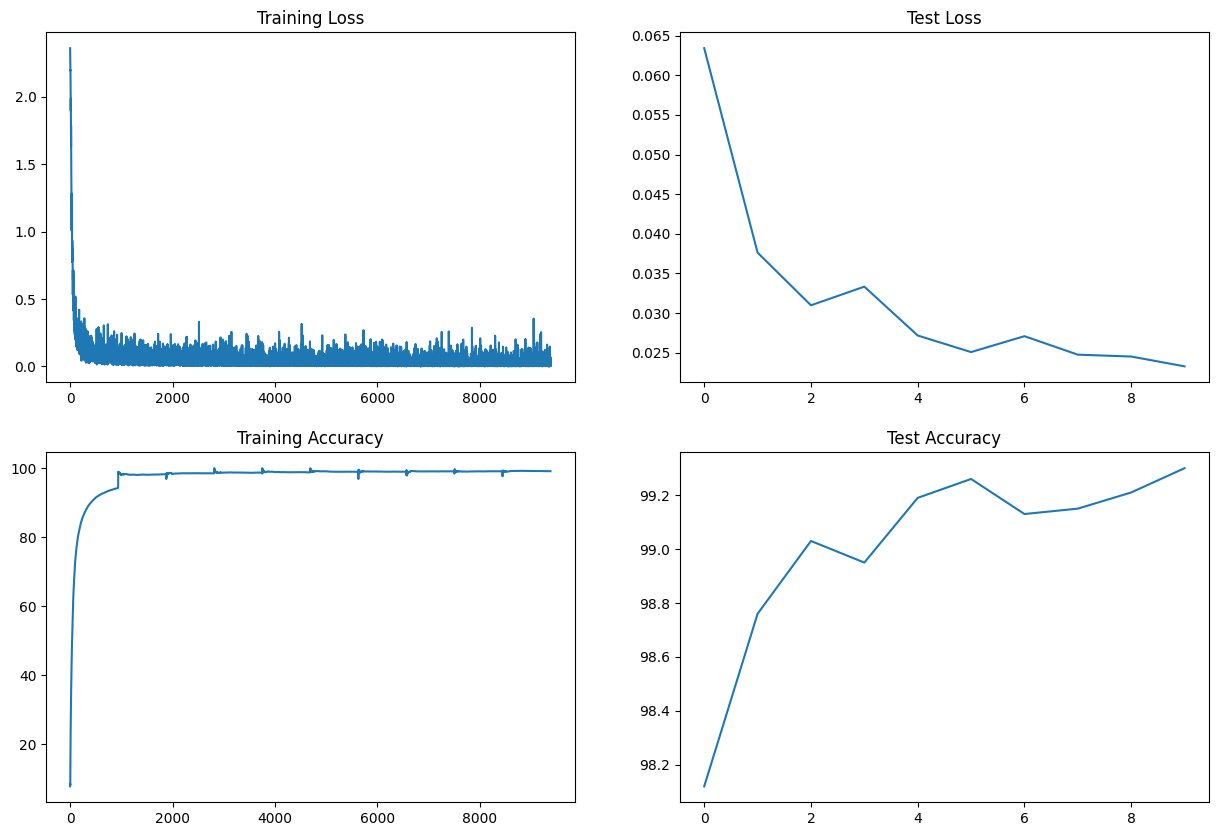

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")